In [1]:
import torch
import torch.nn as nn
import math
import numpy as np
import random
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torchtext.vocab import build_vocab_from_iterator
import re
from transformers import BertTokenizer
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [2]:
from dataloader import *
from transformer import *

# Model definition

In [3]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.kaiming_uniform(m.weight.data)

In [4]:
def plot_training(history, marker=None):
    # put everything on cpu
    for key, value in history.items():
        history[key] = [element.cpu() if isinstance(element, torch.Tensor) else element for element in value]

    plt.subplots_adjust(left=0.1,
                    bottom=0.01,
                    right=1.5,
                    top=0.6,
                    wspace=0.4,
                    hspace=0.4)

    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'])
    plt.plot(history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.title('Training loss')

    # vertical line for marking best epoch
    if marker is not None:
        y_min = min(history['train_loss'] + history['val_loss'])
        y_max = max(history['train_loss'] + history['val_loss'])
        plt.vlines(x=marker, ymin=y_min, ymax=y_max, color='red')

    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'])
    plt.plot(history['val_acc'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.title('Training metric')

    # vertical line for marking best epoch
    if marker is not None:
        y_min = min(history['train_acc'] + history['val_acc'])
        y_max = max(history['train_acc'] + history['val_acc'])
        plt.vlines(x=marker, ymin=y_min, ymax=y_max, color='red')

    plt.show()

In [5]:
def validation(model, iterator, optimizer, criterion, device):
    # set model into evaluation mode
    model.eval()

    # validation
    # loss, metrics for current epoch
    val_epoch_loss = 0
    val_epoch_accuracy = 0

    with torch.no_grad(): # stop graph
        # batches
        for i, batch in enumerate(iterator):
            src = batch[0] # X
            trg = batch[1] # y
            src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device) # put to cpu/gpu
            output = model(src)
            y_pred = torch.argmax(output, dim=-1) # logits -> labels
            output_reshape = output.contiguous().view(-1, output.shape[-1])
            trg = trg.to(torch.int64)

            loss = criterion(output_reshape, trg) # calculate loss
            agreements = torch.eq(y_pred, trg)
            accuracy = torch.mean(agreements.double()) # calculate accuracy

            val_epoch_loss += loss.item()
            val_epoch_accuracy += accuracy

    # return mean loss w.r.t. batches
    return val_epoch_loss / len(iterator), val_epoch_accuracy / len(iterator)

def train(model, iterator, optimizer, criterion, epoch, clip, device):
    # set model into training mode
    model.train()

    scheduler = ReduceLROnPlateau(optimizer, 'min')

    # save data - init
    history = {'train_loss': [],
               'val_loss': [],
               'train_acc': [],
               'val_acc': []}

    # training
    for e in range(epoch):
        # loss, metrics for current epoch
        epoch_loss = 0
        epoch_acc = 0

        # batches
        for i, batch in enumerate(tqdm(iterator)):
            src = batch[0] # X
            trg = batch[1] # y
            src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device) # put to cpu/gpu
            optimizer.zero_grad() # reset optimizer
            output = model(src) # predict
            y_pred = torch.argmax(output, dim=-1) # logits -> labels
            output_reshape = output.contiguous().view(-1, output.shape[-1])
            trg = trg.to(torch.int64)
            loss = criterion(output_reshape, trg) # calculate loss
            agreements = torch.eq(y_pred, trg)
            accuracy = torch.mean(agreements.double()) # calculate accuracy
            loss.backward() # backward pass

            epoch_loss += loss.item()
            epoch_acc += accuracy / len(iterator)

            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step() # optimize model

        # validation
        val_loss, val_acc = validation(model, valid_iter, optimizer, criterion, device)

        # save data
        with torch.no_grad():
          for key, value in zip(history.keys(), [epoch_loss / len(iterator), val_loss, epoch_acc, val_acc]):
            history[key].append(value)

        # visualization
        print(f"Epoch: {e + 1}  Train Loss: {epoch_loss / len(iterator):.4f} \
              Validation Loss: {val_loss:.4f} \
              Train acc: {epoch_acc:.4f}, \
              Val acc: {val_acc:.4f}")

    # print training curve
    plot_training(history)

    return history

def train_save_best(model, iterator, optimizer, criterion, epoch, clip, device):
    # set model into training mode
    model.train()

    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5)

    # save data - init
    history = {'train_loss': [],
               'val_loss': [],
               'train_acc': [],
               'val_acc': [],
               'learning_rate': []}
    best_model = None
    best_model_score = 1e9
    best_model_epoch = 0

    # training
    for e in range(epoch):
        # loss, metrics for current epoch
        epoch_loss = 0
        epoch_acc = 0

        # batches
        for i, batch in enumerate(tqdm(iterator)):
            src = batch[0] # X
            trg = batch[1] # y
            src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device) # put to cpu/gpu
            optimizer.zero_grad() # reset optimizer
            output = model(src) # predict
            y_pred = torch.argmax(output, dim=-1) # logits -> labels
            output_reshape = output.contiguous().view(-1, output.shape[-1])
            trg = trg.to(torch.int64)
            loss = criterion(output_reshape, trg) # calculate loss
            agreements = torch.eq(y_pred, trg)
            accuracy = torch.mean(agreements.double()) # calculate accuracy
            loss.backward() # backward pass

            epoch_loss += loss.item()
            epoch_acc += accuracy / len(iterator)

            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step() # optimize model

        # validation
        val_loss, val_acc = validation(model, valid_iter, optimizer, criterion, device)
        
        scheduler.step(val_loss)

        # save data
        with torch.no_grad():
            current_lr = optimizer.param_groups[0]['lr']

            for key, value in zip(history.keys(), [epoch_loss / len(iterator), val_loss, epoch_acc, val_acc, current_lr]):
                history[key].append(value)

            # save best model (w.r.t validation loss)
            if val_loss < best_model_score:
                best_model = model.state_dict()
                best_model_score = val_loss
                best_model_epoch = e

        # visualization
        print(f"Epoch: {e + 1}  Train Loss: {epoch_loss / len(iterator):.4f} \
              Validation Loss: {val_loss:.4f} \
              Train acc: {epoch_acc:.4f}, \
              Val acc: {val_acc:.4f}, \
              Learning Rate : {optimizer.param_groups[0]['lr'] :.4f}")

    # print training curve
    plot_training(history, marker=best_model_epoch)

    return history, best_model, best_model_score

# Import data

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [7]:
# init
tokenizer = Tokenizer()
loader = DataLoader(tokenize = tokenizer.tokenize)

# import data (combine train/test as we split afterwards anyways)
# data = pd.concat([pd.read_csv("./Data/IMDB Dataset.csv", encoding='ISO-8859-1'),
#                   pd.read_csv("./Data/IMDB Dataset.csv", encoding='ISO-8859-1')])
data = pd.read_csv("./Data/IMDB Dataset.csv", encoding='ISO-8859-1')
# convert string label to binary (int) label (spam:1, non-spam:0)
data["sentiment"] = data['sentiment'].apply(lambda x : int(x == "positive"))

# train, test, val split
train, valid, test = loader.make_dataset(data)
vocab = loader.get_vocab(train.iloc[:, 0])
train_iter, valid_iter, test_iter = loader.make_iter(train, valid, test,
                                                     batch_size=512,
                                                     device=device)

# NLP stuff
pad_idx = vocab['__PAD__']
voc_size = len(vocab)
print("Vocabulary Size : ", voc_size)

# Creating the embedding matrix
embedding = torch.load("Models\embedding_16.pt")

dataset initializing start
Tokenizing the data...


c:\Users\atace\OneDrive\Desktop\ETH\9.Semester\Deep Learning\project\Exploring-Model-Fusion-with-Optimal-Transport-on-Transformers\dataloader.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["len"] = data.iloc[:, 0].apply(lambda x : len(self.tokenize(x)))


Length of the data :  29544
0
review       [[CLS], one, of, the, many, silent, comedies, ...
sentiment                                                    0
len                                                        186
Name: 46539, dtype: object


100%|██████████| 2955/2955 [00:00<00:00, 19700.71it/s]


dataset initializing done
Vocabulary Size :  23050


# Training

Idea: We train model A and model B for long enough, s.t. they start overfitting. We use their best models w.r.t. validation set (i.e. not the final model after all training epochs) and fuse them together. The fused model is then trained for long enough as well, saving the best model w.r.t to the same validation set. The fused model is then compared with its parent models on the separate test set.


note that dataset is imbalanced -> accuracy is not a good metric

  0%|          | 0/47 [00:00<?, ?it/s]C:\Users\atace\AppData\Local\Temp/ipykernel_17468/3037923790.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device) # put to cpu/gpu
100%|██████████| 47/47 [02:39<00:00,  3.39s/it]
C:\Users\atace\AppData\Local\Temp/ipykernel_17468/3037923790.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device) # put to cpu/gpu


Epoch: 1  Train Loss: 0.8023               Validation Loss: 0.7800               Train acc: 0.5052,               Val acc: 0.5001,               Learning Rate : 0.0010


100%|██████████| 47/47 [02:40<00:00,  3.42s/it]


Epoch: 2  Train Loss: 0.6961               Validation Loss: 0.6900               Train acc: 0.5537,               Val acc: 0.5625,               Learning Rate : 0.0010


100%|██████████| 47/47 [02:39<00:00,  3.39s/it]


Epoch: 3  Train Loss: 0.6439               Validation Loss: 0.6746               Train acc: 0.6257,               Val acc: 0.6060,               Learning Rate : 0.0010


100%|██████████| 47/47 [02:40<00:00,  3.40s/it]


Epoch: 4  Train Loss: 0.5856               Validation Loss: 0.6235               Train acc: 0.6861,               Val acc: 0.6681,               Learning Rate : 0.0010


100%|██████████| 47/47 [02:58<00:00,  3.80s/it]


Epoch: 5  Train Loss: 0.5359               Validation Loss: 0.6087               Train acc: 0.7275,               Val acc: 0.6862,               Learning Rate : 0.0010


100%|██████████| 47/47 [03:05<00:00,  3.94s/it]


Epoch: 6  Train Loss: 0.4915               Validation Loss: 0.5750               Train acc: 0.7633,               Val acc: 0.7151,               Learning Rate : 0.0010


100%|██████████| 47/47 [03:06<00:00,  3.96s/it]


Epoch: 7  Train Loss: 0.4597               Validation Loss: 0.5370               Train acc: 0.7806,               Val acc: 0.7461,               Learning Rate : 0.0010


100%|██████████| 47/47 [03:36<00:00,  4.61s/it]


Epoch: 8  Train Loss: 0.4283               Validation Loss: 0.5521               Train acc: 0.8013,               Val acc: 0.7402,               Learning Rate : 0.0010


100%|██████████| 47/47 [03:09<00:00,  4.04s/it]


Epoch: 9  Train Loss: 0.3829               Validation Loss: 0.5167               Train acc: 0.8307,               Val acc: 0.7675,               Learning Rate : 0.0010


100%|██████████| 47/47 [03:08<00:00,  4.02s/it]


Epoch: 10  Train Loss: 0.3666               Validation Loss: 0.4957               Train acc: 0.8366,               Val acc: 0.7750,               Learning Rate : 0.0010


100%|██████████| 47/47 [03:17<00:00,  4.19s/it]


Epoch: 11  Train Loss: 0.3463               Validation Loss: 0.4812               Train acc: 0.8480,               Val acc: 0.7902,               Learning Rate : 0.0010


100%|██████████| 47/47 [02:41<00:00,  3.43s/it]


Epoch: 12  Train Loss: 0.2985               Validation Loss: 0.4963               Train acc: 0.8757,               Val acc: 0.7910,               Learning Rate : 0.0010


100%|██████████| 47/47 [03:23<00:00,  4.34s/it]


Epoch: 13  Train Loss: 0.2750               Validation Loss: 0.4717               Train acc: 0.8852,               Val acc: 0.8001,               Learning Rate : 0.0010


100%|██████████| 47/47 [03:12<00:00,  4.10s/it]


Epoch: 14  Train Loss: 0.2598               Validation Loss: 0.4722               Train acc: 0.8914,               Val acc: 0.8018,               Learning Rate : 0.0010


100%|██████████| 47/47 [02:31<00:00,  3.21s/it]


Epoch: 15  Train Loss: 0.2363               Validation Loss: 0.4641               Train acc: 0.9020,               Val acc: 0.8178,               Learning Rate : 0.0010


100%|██████████| 47/47 [02:54<00:00,  3.72s/it]


Epoch: 16  Train Loss: 0.2150               Validation Loss: 0.4977               Train acc: 0.9155,               Val acc: 0.8095,               Learning Rate : 0.0010


100%|██████████| 47/47 [02:56<00:00,  3.76s/it]


Epoch: 17  Train Loss: 0.2020               Validation Loss: 0.4788               Train acc: 0.9185,               Val acc: 0.8176,               Learning Rate : 0.0010


100%|██████████| 47/47 [03:01<00:00,  3.85s/it]


Epoch: 18  Train Loss: 0.1834               Validation Loss: 0.5451               Train acc: 0.9302,               Val acc: 0.8065,               Learning Rate : 0.0010


100%|██████████| 47/47 [02:55<00:00,  3.74s/it]


Epoch: 19  Train Loss: 0.1722               Validation Loss: 0.4874               Train acc: 0.9346,               Val acc: 0.8266,               Learning Rate : 0.0010


100%|██████████| 47/47 [02:59<00:00,  3.82s/it]


Epoch: 20  Train Loss: 0.1689               Validation Loss: 0.4992               Train acc: 0.9333,               Val acc: 0.8301,               Learning Rate : 0.0010


100%|██████████| 47/47 [03:00<00:00,  3.84s/it]


Epoch: 21  Train Loss: 0.1521               Validation Loss: 0.5487               Train acc: 0.9436,               Val acc: 0.8166,               Learning Rate : 0.0001


100%|██████████| 47/47 [03:20<00:00,  4.27s/it]


Epoch: 22  Train Loss: 0.1353               Validation Loss: 0.5003               Train acc: 0.9526,               Val acc: 0.8294,               Learning Rate : 0.0001


100%|██████████| 47/47 [03:14<00:00,  4.14s/it]


Epoch: 23  Train Loss: 0.1266               Validation Loss: 0.5073               Train acc: 0.9568,               Val acc: 0.8275,               Learning Rate : 0.0001


100%|██████████| 47/47 [03:06<00:00,  3.97s/it]


Epoch: 24  Train Loss: 0.1242               Validation Loss: 0.5046               Train acc: 0.9586,               Val acc: 0.8296,               Learning Rate : 0.0001


100%|██████████| 47/47 [03:14<00:00,  4.14s/it]


Epoch: 25  Train Loss: 0.1233               Validation Loss: 0.5044               Train acc: 0.9585,               Val acc: 0.8290,               Learning Rate : 0.0001


100%|██████████| 47/47 [03:15<00:00,  4.16s/it]


Epoch: 26  Train Loss: 0.1213               Validation Loss: 0.5054               Train acc: 0.9600,               Val acc: 0.8318,               Learning Rate : 0.0001


100%|██████████| 47/47 [03:19<00:00,  4.25s/it]


Epoch: 27  Train Loss: 0.1191               Validation Loss: 0.5055               Train acc: 0.9614,               Val acc: 0.8326,               Learning Rate : 0.0000


100%|██████████| 47/47 [03:20<00:00,  4.27s/it]


Epoch: 28  Train Loss: 0.1165               Validation Loss: 0.5056               Train acc: 0.9622,               Val acc: 0.8340,               Learning Rate : 0.0000


100%|██████████| 47/47 [03:25<00:00,  4.37s/it]


Epoch: 29  Train Loss: 0.1159               Validation Loss: 0.5050               Train acc: 0.9625,               Val acc: 0.8326,               Learning Rate : 0.0000


100%|██████████| 47/47 [03:13<00:00,  4.11s/it]


Epoch: 30  Train Loss: 0.1159               Validation Loss: 0.5065               Train acc: 0.9630,               Val acc: 0.8323,               Learning Rate : 0.0000


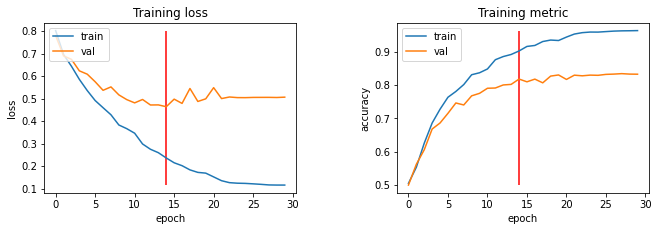

Wall time: 1h 38min 15s


In [8]:
%%time
# train model A
modelA = TransformerClassifier(embedding=embedding,
                              src_pad_idx = pad_idx,
                              enc_voc_size = voc_size,
                              max_len = 256,
                              d_model = 16,
                              ffn_hidden = 32,
                              n_head = 4,
                              n_layers = 1,
                              drop_prob = 0.5,
                              device = device)
modelA = modelA.to(device) # put on CPU/GPU

optA = torch.optim.Adam(modelA.parameters(), lr=0.001)
loss_fnA = nn.CrossEntropyLoss()


epochs = 30

historyA, best_modelA, best_model_scoreA = train_save_best(model=modelA,
                                                            iterator=train_iter,
                                                            optimizer=optA,
                                                            criterion=loss_fnA,
                                                            epoch=epochs,
                                                            clip=1,
                                                            device=device)

# save model
torch.save(best_modelA, './Models/modelA_IMDB_256_multihead')

# save history
with open('./Models/history_modelA_IMDB_256_multihead.txt', 'w') as dat:
    dat.write(str(historyA))

  0%|          | 0/47 [00:00<?, ?it/s]C:\Users\atace\AppData\Local\Temp/ipykernel_17468/3037923790.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device) # put to cpu/gpu
100%|██████████| 47/47 [03:32<00:00,  4.52s/it]
C:\Users\atace\AppData\Local\Temp/ipykernel_17468/3037923790.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device) # put to cpu/gpu


Epoch: 1  Train Loss: 0.7545               Validation Loss: 0.6501               Train acc: 0.5481,               Val acc: 0.6137,               Learning Rate : 0.0010


100%|██████████| 47/47 [03:16<00:00,  4.19s/it]


Epoch: 2  Train Loss: 0.4759               Validation Loss: 0.4988               Train acc: 0.7503,               Val acc: 0.7416,               Learning Rate : 0.0010


100%|██████████| 47/47 [03:22<00:00,  4.31s/it]


Epoch: 3  Train Loss: 0.3179               Validation Loss: 0.3703               Train acc: 0.8598,               Val acc: 0.8346,               Learning Rate : 0.0010


100%|██████████| 47/47 [03:15<00:00,  4.17s/it]


Epoch: 4  Train Loss: 0.2411               Validation Loss: 0.3603               Train acc: 0.8993,               Val acc: 0.8556,               Learning Rate : 0.0010


100%|██████████| 47/47 [02:57<00:00,  3.78s/it]


Epoch: 5  Train Loss: 0.1959               Validation Loss: 0.3573               Train acc: 0.9203,               Val acc: 0.8589,               Learning Rate : 0.0010


100%|██████████| 47/47 [03:06<00:00,  3.97s/it]


Epoch: 6  Train Loss: 0.1637               Validation Loss: 0.4068               Train acc: 0.9354,               Val acc: 0.8423,               Learning Rate : 0.0010


100%|██████████| 47/47 [03:12<00:00,  4.10s/it]


Epoch: 7  Train Loss: 0.1342               Validation Loss: 0.3783               Train acc: 0.9509,               Val acc: 0.8668,               Learning Rate : 0.0010


100%|██████████| 47/47 [03:08<00:00,  4.01s/it]


Epoch: 8  Train Loss: 0.1047               Validation Loss: 0.4201               Train acc: 0.9648,               Val acc: 0.8640,               Learning Rate : 0.0010


100%|██████████| 47/47 [03:17<00:00,  4.21s/it]


Epoch: 9  Train Loss: 0.1019               Validation Loss: 0.4277               Train acc: 0.9635,               Val acc: 0.8627,               Learning Rate : 0.0010


100%|██████████| 47/47 [03:17<00:00,  4.21s/it]


Epoch: 10  Train Loss: 0.0794               Validation Loss: 0.4481               Train acc: 0.9750,               Val acc: 0.8613,               Learning Rate : 0.0010


100%|██████████| 47/47 [03:08<00:00,  4.02s/it]


Epoch: 11  Train Loss: 0.0686               Validation Loss: 0.4642               Train acc: 0.9788,               Val acc: 0.8616,               Learning Rate : 0.0001


100%|██████████| 47/47 [02:59<00:00,  3.81s/it]


Epoch: 12  Train Loss: 0.0533               Validation Loss: 0.4644               Train acc: 0.9870,               Val acc: 0.8627,               Learning Rate : 0.0001


100%|██████████| 47/47 [02:55<00:00,  3.73s/it]


Epoch: 13  Train Loss: 0.0513               Validation Loss: 0.4684               Train acc: 0.9878,               Val acc: 0.8592,               Learning Rate : 0.0001


100%|██████████| 47/47 [02:59<00:00,  3.81s/it]


Epoch: 14  Train Loss: 0.0501               Validation Loss: 0.4722               Train acc: 0.9881,               Val acc: 0.8601,               Learning Rate : 0.0001


100%|██████████| 47/47 [02:56<00:00,  3.75s/it]


Epoch: 15  Train Loss: 0.0491               Validation Loss: 0.4833               Train acc: 0.9886,               Val acc: 0.8581,               Learning Rate : 0.0001


100%|██████████| 47/47 [03:04<00:00,  3.92s/it]


Epoch: 16  Train Loss: 0.0484               Validation Loss: 0.4816               Train acc: 0.9881,               Val acc: 0.8615,               Learning Rate : 0.0001


100%|██████████| 47/47 [02:38<00:00,  3.37s/it]


Epoch: 17  Train Loss: 0.0465               Validation Loss: 0.4899               Train acc: 0.9892,               Val acc: 0.8586,               Learning Rate : 0.0000


100%|██████████| 47/47 [02:48<00:00,  3.58s/it]


Epoch: 18  Train Loss: 0.0466               Validation Loss: 0.4849               Train acc: 0.9891,               Val acc: 0.8611,               Learning Rate : 0.0000


100%|██████████| 47/47 [03:01<00:00,  3.86s/it]


Epoch: 19  Train Loss: 0.0455               Validation Loss: 0.4896               Train acc: 0.9895,               Val acc: 0.8609,               Learning Rate : 0.0000


100%|██████████| 47/47 [02:50<00:00,  3.63s/it]


Epoch: 20  Train Loss: 0.0460               Validation Loss: 0.4790               Train acc: 0.9892,               Val acc: 0.8645,               Learning Rate : 0.0000


100%|██████████| 47/47 [03:02<00:00,  3.88s/it]


Epoch: 21  Train Loss: 0.0458               Validation Loss: 0.4833               Train acc: 0.9890,               Val acc: 0.8631,               Learning Rate : 0.0000


100%|██████████| 47/47 [03:01<00:00,  3.85s/it]


Epoch: 22  Train Loss: 0.0449               Validation Loss: 0.4829               Train acc: 0.9899,               Val acc: 0.8621,               Learning Rate : 0.0000


100%|██████████| 47/47 [02:51<00:00,  3.64s/it]


Epoch: 23  Train Loss: 0.0449               Validation Loss: 0.4858               Train acc: 0.9898,               Val acc: 0.8609,               Learning Rate : 0.0000


100%|██████████| 47/47 [02:50<00:00,  3.62s/it]


Epoch: 24  Train Loss: 0.0450               Validation Loss: 0.4870               Train acc: 0.9895,               Val acc: 0.8622,               Learning Rate : 0.0000


100%|██████████| 47/47 [02:52<00:00,  3.67s/it]


Epoch: 25  Train Loss: 0.0453               Validation Loss: 0.4865               Train acc: 0.9898,               Val acc: 0.8626,               Learning Rate : 0.0000


100%|██████████| 47/47 [02:57<00:00,  3.78s/it]


Epoch: 26  Train Loss: 0.0448               Validation Loss: 0.4886               Train acc: 0.9902,               Val acc: 0.8621,               Learning Rate : 0.0000


100%|██████████| 47/47 [02:55<00:00,  3.73s/it]


Epoch: 27  Train Loss: 0.0444               Validation Loss: 0.4816               Train acc: 0.9901,               Val acc: 0.8627,               Learning Rate : 0.0000


100%|██████████| 47/47 [03:04<00:00,  3.92s/it]


Epoch: 28  Train Loss: 0.0452               Validation Loss: 0.4850               Train acc: 0.9897,               Val acc: 0.8630,               Learning Rate : 0.0000


100%|██████████| 47/47 [03:05<00:00,  3.94s/it]


Epoch: 29  Train Loss: 0.0449               Validation Loss: 0.4868               Train acc: 0.9902,               Val acc: 0.8621,               Learning Rate : 0.0000


100%|██████████| 47/47 [03:03<00:00,  3.90s/it]


Epoch: 30  Train Loss: 0.0446               Validation Loss: 0.4900               Train acc: 0.9899,               Val acc: 0.8619,               Learning Rate : 0.0000


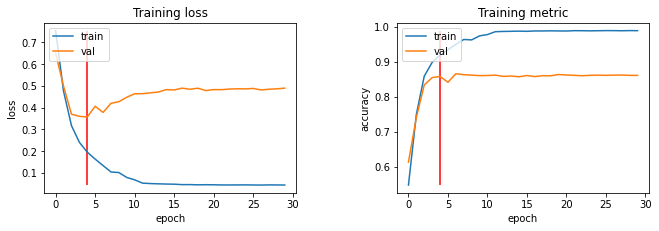

Wall time: 1h 37min 43s


In [10]:
%%time
# train model B
modelB = TransformerClassifier(embedding=embedding,
                              src_pad_idx = pad_idx,
                              enc_voc_size = voc_size,
                              max_len = 256,
                              d_model = 16,
                              ffn_hidden = 32,
                              n_head = 4,
                              n_layers = 1,
                              drop_prob = 0.5,
                              device = device)
modelB = modelB.to(device) # put on CPU/GPU

optB = torch.optim.Adam(modelB.parameters(), lr=0.001)
loss_fnB = nn.CrossEntropyLoss()


epochs = 30

historyB, best_modelB, best_model_scoreB = train_save_best(model=modelB,
                                                            iterator=train_iter,
                                                            optimizer=optB,
                                                            criterion=loss_fnB,
                                                            epoch=epochs,
                                                            clip=1,
                                                            device=device)

# save model
torch.save(best_modelB, './Models/modelB_IMDB_256_multihead')

# save history
with open('./Models/history_modelB_IMDB_256_multihead.txt', 'w') as dat:
    dat.write(str(historyB))

# Model fusion

### Definitions

In [ ]:
def weight_averaging(*weights):
  with torch.no_grad():
    sum = torch.zeros(weights[0].shape, device=device)
    for weight in weights:
      sum += weight
  return sum / len(weights)

In [ ]:
def linear_averaging(*linears):
  """Averages several linear layers (weights + biases)"""
  with torch.no_grad():
    weights = [linear.weight for linear in linears]
    biases = [linear.bias for linear in linears]

    linear_averaged = torch.nn.Linear(linears[0].in_features, linears[0].out_features, bias=True).to(device)
    linear_averaged.weight, linear_averaged.bias = torch.nn.Parameter(weight_averaging(*weights)), torch.nn.Parameter(weight_averaging(*biases))

  return linear_averaged

In [ ]:
def vanilla_fusion(modelA, modelB):
  # init
  model_fusion = TransformerClassifier(src_pad_idx = pad_idx,
                              enc_voc_size = voc_size,
                              max_len = 256,
                              d_model = 512,
                              ffn_hidden = 2048,
                              n_head = 1,
                              n_layers = 1,
                              drop_prob = 0.1,
                              device = device)

  with torch.no_grad():
    # 1) encoder
    # TODO: smarter method for embedding
    # a) embedding
    weights_A = modelA.encoder.emb.tok_emb.weight
    weights_B = modelB.encoder.emb.tok_emb.weight

    weights_fusion = weight_averaging(weights_A, weights_B) # weights seem to be exactly the same?
    model_fusion.encoder.emb.tok_emb.weight = torch.nn.Parameter(weights_fusion)

    # b) encoder layers
    for i, _ in enumerate(modelA.encoder.layers):
      # i) self-attention (fuse Q, K, V separately) # TODO: check validity of this approach
      # query
      query_A = modelA.encoder.layers[i].attention.w_q
      query_B = modelB.encoder.layers[i].attention.w_q

      query_fusion = linear_averaging(query_A, query_B)
      model_fusion.encoder.layers[i].attention.w_q = query_fusion

      # key
      key_A = modelA.encoder.layers[i].attention.w_k
      key_B = modelB.encoder.layers[i].attention.w_k

      key_fusion = linear_averaging(key_A, key_B)
      model_fusion.encoder.layers[i].attention.w_k = key_fusion

      # value
      value_A = modelA.encoder.layers[i].attention.w_v
      value_B = modelB.encoder.layers[i].attention.w_v

      value_fusion = linear_averaging(value_A, value_B)
      model_fusion.encoder.layers[i].attention.w_v = value_fusion

      # output
      output_A = modelA.encoder.layers[i].attention.w_concat
      output_B = modelB.encoder.layers[i].attention.w_concat

      output_fusion = linear_averaging(output_A, output_B)
      model_fusion.encoder.layers[i].attention.w_concat = output_fusion

      # ii) layer norm 1
      # TODO: LAYER NORM WEIGHTS ARE NOT CALLABLE???

      # iii) feed-forward network
      # layer 1
      linear_A = modelA.encoder.layers[i].ffn.linear1
      linear_B = modelB.encoder.layers[i].ffn.linear1

      linear_fusion = linear_averaging(linear_A, linear_B)
      model_fusion.encoder.layers[i].ffn.linear1 = linear_fusion

      # layer 2
      linear_A = modelA.encoder.layers[i].ffn.linear2
      linear_B = modelB.encoder.layers[i].ffn.linear2

      linear_fusion = linear_averaging(linear_A, linear_B)
      model_fusion.encoder.layers[i].ffn.linear2 = linear_fusion

      # iv) layer norm 2
      # TODO: LAYER NORM WEIGHTS ARE NOT CALLABLE???

    # 2) MLP head
    linear_A = modelA.linear
    linear_B = modelB.linear

    linear_fusion = linear_averaging(linear_A, linear_B)
    model_fusion.linear = linear_fusion

  return model_fusion

In [ ]:
def test_fusion(modelA, modelB, model_fusion):
  # test fusion
  test_loss_A, test_acc_A = validation(modelA, test_iter, None, nn.CrossEntropyLoss(), device)
  test_loss_B, test_acc_B = validation(modelB, test_iter, None, nn.CrossEntropyLoss(), device)
  test_loss_fusion, test_acc_fusion = validation(model_fusion, test_iter, None, nn.CrossEntropyLoss(), device)

  # visualize
  fig, ax = plt.subplots()

  metrics_A = [test_loss_A, test_acc_A]
  metrics_B = [test_loss_B, test_acc_B]
  metrics_fusion = [test_loss_fusion, test_acc_fusion]
  metrics = ['loss', 'accuracy']
  x = np.arange(len(metrics)) # positions of bars (1 per metric)
  width = 0.25  # the width of the bars

  rects1 = ax.bar(x - width, metrics_A, width, label='model A')
  rects2 = ax.bar(x, metrics_B, width, label='model B')
  rects3 = ax.bar(x + width, metrics_fusion, width, label='model fusion')

  ax.set_ylabel('Score')
  ax.set_title('Test metrics by models')
  ax.set_xticks(x)
  ax.set_xticklabels(metrics)
  ax.legend()

  plt.show()

### (Optional) load models

In [ ]:
# load parent models
# TODO: change enc_voc_size back
modelA = TransformerClassifier(src_pad_idx = pad_idx,
                              enc_voc_size = voc_size,
                              max_len = 256,
                              d_model = 512,
                              ffn_hidden = 2048,
                              n_head = 1,
                              n_layers = 1,
                              drop_prob = 0.1,
                              device = device)
modelB = TransformerClassifier(src_pad_idx = pad_idx,
                              enc_voc_size = voc_size,
                              max_len = 256,
                              d_model = 512,
                              ffn_hidden = 2048,
                              n_head = 1,
                              n_layers = 1,
                              drop_prob = 0.1,
                              device = device)

modelA.load_state_dict(torch.load('./Models/modelA'))
modelB.load_state_dict(torch.load('./Models/modelB'))

### Fusion

Vanilla fusion

In [ ]:
model_fusion = vanilla_fusion(modelA, modelB)

Optimal transport

In [ ]:
model_fusion = TransformerClassifier(src_pad_idx = pad_idx,
                               enc_voc_size = voc_size,
                               max_len = 256,
                               d_model = 512,
                               ffn_hidden = 2048,
                               n_head = 1,
                               n_layers = 1,
                               drop_prob = 0.1,
                               device = device)

model_fusion.load_state_dict(torch.load('./Models/model_fusion_OT_pre_retraining'))

### Test fusion

Randomly initialiized model for comparison

In [ ]:
# test with new randomly initialized transformer
test_fusion(modelA, modelB, TransformerClassifier(src_pad_idx = pad_idx,
                              enc_voc_size = voc_size,
                              max_len = 256,
                              d_model = 512,
                              ffn_hidden = 2048,
                              n_head = 1,
                              n_layers = 1,
                              drop_prob = 0.1,
                              device = device))

Fusion model

In [ ]:
# test with vanilla fusion
test_fusion(modelA, modelB, model_fusion)

### Retraining

In [ ]:
model_name = 'model_fusion_OT_post_retraining'

In [ ]:
%%time
opt_fusion = torch.optim.SGD(model_fusion.parameters(), lr=0.001)
loss_fn_fusion = nn.CrossEntropyLoss()


epochs = 200
history_fusion, best_model_fusion, best_model_score_fusion = train_save_best(model=model_fusion,
                                                                             iterator=train_iter,
                                                                             optimizer=opt_fusion,
                                                                             criterion=loss_fn_fusion,
                                                                             epoch=epochs,
                                                                             clip=1,
                                                                             device=device)

In [ ]:
# save model
torch.save(best_model_fusion, f'./Models/{model_name}')

# save history
with open(f'./Models/history_{model_name}.txt', 'w') as dat:
    dat.write(str(history_fusion))

In [ ]:
# load best model (current model is trained on full epochs)
model_fusion.load_state_dict(best_model_fusion)

### Test fusion (after retraining)

In [ ]:
# test with vanilla fusion
test_fusion(modelA, modelB, model_fusion)